# Polarization Leakage

Import some packages

In [8]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io.votable import parse
from astropy.coordinates import SkyCoord

In [ ]:
import matplotlib
from astropy.wcs import WCS
import astropy.wcs.utils as wcs

from astropy.visualization import (MinMaxInterval, ImageNormalize, PercentileInterval)
from astropy.visualization import SqrtStretch
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
import glob
import pandas as pd

#import healpy as hp

from regions import RectangleSkyRegion, PixCoord, RectanglePixelRegion

Some utility functions

In [2]:
def votable_to_pandas(votable_file):
    votable = parse(votable_file)
    table = votable.get_first_table().to_table(use_names_over_ids=True)
    return table.to_pandas()

def read_centers(filename):
    #assumes format of ID (x, y) hh:mm:ss.sss,+/-dd:mm:ss.ss
    data=np.genfromtxt(filename,skip_header=0,delimiter=';',dtype=str)
    centers=[]
    for i in range(data.shape[0]):
        aa=data[i].split('  ')
        if len(aa)==3:
            bb=aa[2].split(',')
        if len(aa)==4:
            bb=aa[3].split(',')
        #print i,len(bb),bb
        centers.append(bb[0]+' '+bb[1])
    return centers

def hms2skycoord(centers):
    #takes string in format "hh:mm:ss.sss +/-dd:mm:ss.ss" returns skycoordinate array
    coords=SkyCoord(centers,frame='fk5',unit=(u.hourangle,u.deg))
    return coords

def getpoints(ra=[],dec=[],filename=[],delimiter=','):
    #either reads in point positions from filename or takes ra, dec (in degrees) array and converts to skycoord array. filename should hae format ra (in degrees) , dec (in degrees), if not comma separated then set delimiter
    if len(ra)==0:
        ra,dec=np.genfromtxt(filename,delimiter=delimiter)
    points=SkyCoord(ra*u.deg,dec*u.deg,frame='fk5')
    
    return points

def dists(coords,points):
    #computes distance from coords to points in degrees
    distances=np.zeros((coords.size,points.size))
    for i in range(coords.size):
        distances[i,:]=coords[i].separation(points).value
    
    return distances
    
def angles(coords,points):
    #computes distance from coords to points in degrees
    posangle=np.zeros((coords.size,points.size))
    for i in range(coords.size):
        posangle[i,:]=coords[i].position_angle(points).degree
    
    return posangle

def getAllBeamDistances(footfile, ra, dec):
    beamCentres=read_centers(footfile)
    beamCoords=hms2skycoord(beamCentres)
    points1=getpoints(ra, dec)
    distances=dists(beamCoords,points1)
    posangles=angles(beamCoords,points1)
    #beam_dist,pa,beam_num=mindists_and_angles(distances,posangles)
    return distances,posangles


/Users/jenniferwest/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/jenniferwest/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/jenniferwest/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same argum

/Users/jenniferwest/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/jenniferwest/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/jenniferwest/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same argum

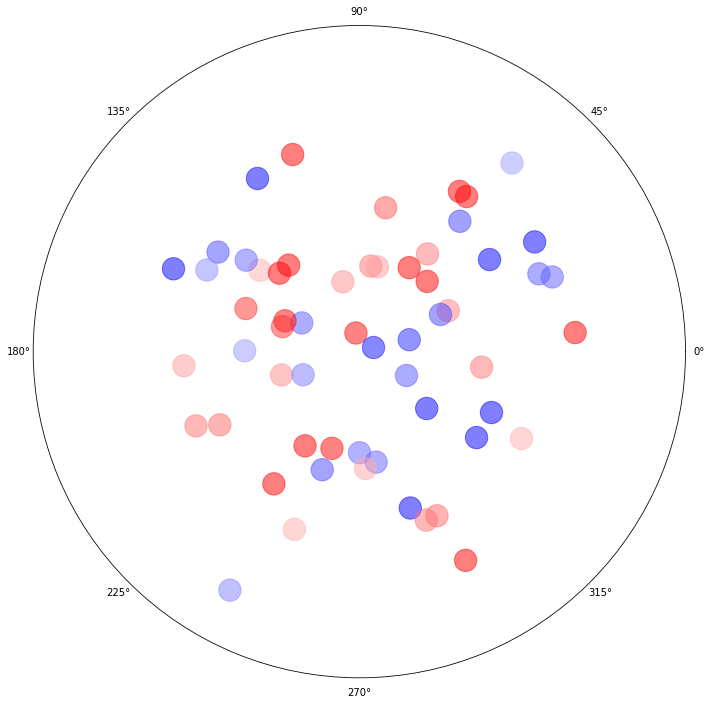

In [9]:

footfile = "../data/footprintOutput-sb66043-src1-WALLABY_1002-37B.txt"
headerrows=2
fluxlim = 10
beams = ["00", "01", "02", "03", "04", "05", "06", "07", "08", "09",
        "10", "11", "12", "13", "14", "15", "16", "17", "18", "19",
        "20", "21", "22", "23", "24", "25", "26", "27", "28", "29",
        "30", "31", "32", "33", "34", "35"]

#beams = ["08","09","14","15","16","19","20","21","22","26","27","28"]

fig = plt.figure(figsize=(12,12)) 
for beam in beams:
    selavy = "../data/cats/selavy-image.i.EMU_0721-51.SB65906.cont.EMU_0721-51.beam"+beam+".taylor.0.restored.polarisation.xml"
    selavy = "../data/band2cats/selavy-image.i.WALLABY_1002-37B.SB66043.cont.WALLABY_1002-37B.beam"+beam+".taylor.0.restored.polarisation.xml"

    df = votable_to_pandas(selavy)
    df = df[df["flux_I_median"] > fluxlim]
    df = df[np.abs(df["flux_Q_median"]/df["flux_I_median"]) > 0.003]
    df = df[df["pol_peak_fit_snr"] < 10]
    df = df.sort_values("flux_I_median")
    
    ra = df["ra_deg_cont"].values
    dec = df["dec_deg_cont"].values
    #print(len(ra))
    if (len(ra)==0):
        pass
    else:
        dist, pa = getAllBeamDistances(footfile, ra, dec)
        dist = dist[int(beam),:]
        pa = pa[int(beam),:]
        myalpha=df["flux_I_median"].values/np.mean(df["flux_I_median"].values)
    
        ax = fig.add_subplot(1,1, 1, projection='polar')
        ax.scatter(pa, dist, c=df["flux_Q_median"]/df["flux_I_median"], cmap="bwr_r", s=500, alpha=0.5,vmin=-0.01, vmax=0.01)
        ax.grid(False)
        ax.set_yticklabels([])
    
    

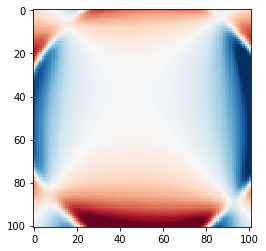

In [15]:
holofile = "../data/akpb.iquv.closepack36.54.943MHz.SB64315.cube.fits"
holodata = fits.getdata(holofile)
holohead = fits.getheader(holofile)

# Stokes values:
# 0 for I
# 1 for Q
# 2 for U
# 3 for V
stokes = 1

# beams 0 to 35
beam = 20 

#frequency channel number 0 to 287
nu = 130

holoq = holodata[beam,stokes,nu,:,:]
plt.imshow(holoq, vmin=-0.5, vmax=0.5, cmap="RdBu_r")


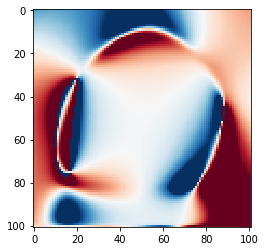

In [14]:
holofile = "../data/akpb.iquv.square_6x6.54.1295MHz.SB65272.cube.fits"
holodata = fits.getdata(holofile)
holohead = fits.getheader(holofile)

# Stokes values:
# 0 for I
# 1 for Q
# 2 for U
# 3 for V
stokes = 1

# beams 0 to 35
beam = 20 

#frequency channel number 0 to 143
nu = 130

holoq = holodata[beam,stokes,nu,:,:]
plt.imshow(holoq, vmin=-0.5, vmax=0.5, cmap="RdBu_r")
